In [1]:
import numpy as np
from scipy.io import loadmat
import cv2
m = loadmat('hw3Data/TrainingSamplesDCT_subsets_8.mat')
p1 = loadmat('hw3Data/Prior_1.mat')
p2 = loadmat('hw3Data/Prior_2.mat')
alpha = loadmat('hw3Data/Alpha.mat')

In [2]:
BG1,BG2,BG3,BG4 = m['D1_BG'],m['D2_BG'],m['D3_BG'],m['D4_BG']
FG1,FG2,FG3,FG4 = m['D1_FG'],m['D2_FG'],m['D3_FG'],m['D4_FG']
w0_1,mu0_FG_1,mu0_BG_1 = p1['W0'],p1['mu0_FG'].T,p1['mu0_BG'].T
w0_2,mu0_FG_2,mu0_BG_2 = p2['W0'],p2['mu0_FG'].T,p2['mu0_BG'].T
a = alpha['alpha']

In [3]:
BG = [BG1,BG2,BG3,BG4]
FG = [FG1,FG2,FG3,FG4]
w0 = [w0_1,w0_2]
mu0_FG = [mu0_FG_1,mu0_FG_2]
mu0_BG = [mu0_BG_1,mu0_BG_2]

In [4]:
cov_FG,cov_BG = [],[]
mu_FG,mu_BG = [],[]
for i in range(len(FG)):
    FG_cov = np.cov(FG[i].T) * (FG[i].shape[0]-1)/(FG[i].shape[0])
    BG_cov = np.cov(BG[i].T) * (BG[i].shape[0]-1)/(BG[i].shape[0])
    FG_mu = np.mean(FG[i],axis = 0)[:,np.newaxis]
    BG_mu = np.mean(BG[i],axis = 0)[:,np.newaxis]
    cov_FG.append(FG_cov)
    cov_BG.append(BG_cov)
    mu_FG.append(FG_mu)
    mu_BG.append(BG_mu)

In [5]:
temp = a.T.dot(w0[0])
cov0 = np.zeros((9,4096))
cov0[:,[i for i in range(0,4097,65)]] += temp
cov0_1 = cov0.reshape(9,64,64)

In [6]:
temp = a.T.dot(w0[1])
cov0 = np.zeros((9,4096))
cov0[:,[i for i in range(0,4097,65)]] += temp
cov0_2 = cov0.reshape(9,64,64)

In [7]:
cov0 = [cov0_1,cov0_2]

In [8]:
from numpy.linalg import inv,det
cov1_FG_1,cov1_FG_2 = [],[]
cov1_BG_1,cov1_BG_2 = [],[]
mu1_FG_1,mu1_FG_2 = [],[]
mu1_BG_1,mu1_BG_2 = [],[]
for i in range(len(FG)):
    for j in range(len(cov0)):
        mu1_FG,mu1_BG = np.zeros(shape = (9,64,1),dtype = 'float'),np.zeros(shape = (9,64,1),dtype = 'float')
        cov1_FG,cov1_BG = np.zeros(shape = (9,64,64),dtype = 'float'),np.zeros(shape = (9,64,64),dtype = 'float')
        for k in range(a.shape[1]):
            cov0_FG,cov0_BG = cov0[j][k],cov0[j][k]
            weight1_FG = cov0_FG.dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))
            weight1_BG = cov0_BG.dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))
            weight2_FG = (cov_FG[i]/FG[i].shape[0]).dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))
            weight2_BG = (cov_BG[i]/BG[i].shape[0]).dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))
            FG_mu1 = weight1_FG.dot(mu_FG[i]) + weight2_FG.dot(mu0_FG[j])
            BG_mu1 = weight1_BG.dot(mu_BG[i]) + weight2_BG.dot(mu0_BG[j])
            FG_cov1 = (cov0_FG.dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))).dot(cov_FG[i]/FG[i].shape[0])
            BG_cov1 = (cov0_BG.dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))).dot(cov_BG[i]/BG[i].shape[0])
            mu1_FG[k] = mu1_FG[k] + FG_mu1
            mu1_BG[k] = mu1_BG[k] + BG_mu1
            cov1_FG[k] = cov1_FG[k] + FG_cov1
            cov1_BG[k] = cov1_BG[k] + BG_cov1
        if j == 0:
            cov1_FG_1.append(cov1_FG)
            cov1_BG_1.append(cov1_BG)
            mu1_FG_1.append(mu1_FG)
            mu1_BG_1.append(mu1_BG)
        else:
            cov1_FG_2.append(cov1_FG)
            cov1_BG_2.append(cov1_BG)
            mu1_FG_2.append(mu1_FG)
            mu1_BG_2.append(mu1_BG)

In [9]:
mu1_pred_FG_1,mu1_pred_FG_2 = mu1_FG_1,mu1_FG_2
mu1_pred_BG_1,mu1_pred_BG_2 = mu1_BG_1,mu1_BG_2
cov1_pred_FG_1,cov1_pred_FG_2 = [],[]
cov1_pred_BG_1,cov1_pred_BG_2 = [],[]
for i in range(len(FG)):
    FG_1 = cov1_FG_1[i] + cov_FG[i]
    FG_2 = cov1_FG_2[i] + cov_FG[i]
    BG_1 = cov1_BG_1[i] + cov_BG[i]
    BG_2 = cov1_BG_2[i] + cov_BG[i]
    cov1_pred_FG_1.append(FG_1)
    cov1_pred_FG_2.append(FG_2)
    cov1_pred_BG_1.append(BG_1)
    cov1_pred_BG_2.append(BG_2)

In [10]:
prior_cheetah,prior_grass = [],[]
for i in range(len(FG)):
    prior_cheetah.append(FG[i].shape[0]/(FG[i].shape[0]+BG[i].shape[0]))
    prior_grass.append(BG[i].shape[0]/(FG[i].shape[0]+BG[i].shape[0]))
prior_cheetah = np.array(prior_cheetah)
prior_grass = np.array(prior_grass)
print(prior_cheetah)

[0.2 0.2 0.2 0.2]


In [11]:
# define the zigzag transformation
zig_zag = np.array([[0,1,5,6,14,15,27,28],[2,4,7,13,16,26,29,42],[3,8,12,17,25,30,41,43],
                   [9,11,18,24,31,40,44,53],[10,19,23,32,39,45,52,54],[20,22,33,38,46,51,55,60],
                   [21,34,37,47,50,56,59,61],[35,36,48,49,57,58,62,63]])
zz_flat = zig_zag.flatten()
def zig_zag_transform(a):
    result = np.zeros(64)
    for i in range(64):
        result[zz_flat[i]] = a[i]
    return result

In [12]:
# 2D DCT function
import scipy.fftpack
def dct2d(a):
    return scipy.fftpack.dct(scipy.fftpack.dct( a, axis=0, norm='ortho' ),axis=1,norm='ortho')

In [13]:
im = cv2.imread('cheetah.bmp', cv2.IMREAD_GRAYSCALE)
im_array = im
print(im_array.shape)

(255, 270)


In [14]:
import cv2

# store the test data as a numpy array
im_test = cv2.imread('cheetah_mask.bmp', cv2.IMREAD_GRAYSCALE)
im_test_array = np.array(im_test, dtype = float)
# convert 255 to 1 for error calculation
im_test_array = im_test_array / 255

In [15]:
# BDR using Beysian Parameter Estimation using prior 1
error_list_1,error_list_2=[],[]
for t in range(len(FG)):
    A_list = []
    for k in range(cov1_pred_FG_1[t].shape[0]):
        A = []
        cov_pred_FG_inv = inv(cov1_pred_FG_1[t][k])
        cov_pred_BG_inv = inv(cov1_pred_BG_1[t][k])
        cov_pred_FG_det = det(cov1_pred_FG_1[t][k])
        cov_pred_BG_det = det(cov1_pred_BG_1[t][k])
        for i in range(0,len(im_array)-8):
            for j in range(0,im_array.shape[1]-8):
                FG_prob,BG_prob = 0,0
                row_start,row_end = i,i+8
                col_start,col_end = j,j+8
                block = im_array[row_start:row_end,col_start:col_end]
                block_dct = dct2d(block).flatten()
                block_dct = zig_zag_transform(block_dct)
                # foreground
                temp1 = block_dct[:,np.newaxis] - mu1_pred_FG_1[t][k]
                temp2 = (temp1.T.dot(cov_pred_FG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_FG_det) - 2 * np.log(prior_cheetah[t])
                FG_prob = temp2 + temp3
                #background
                temp1 = block_dct[:,np.newaxis] - mu1_pred_BG_1[t][k]
                temp2 = (temp1.T.dot(cov_pred_BG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_BG_det) - 2 * np.log(prior_grass[t])
                BG_prob = temp2 + temp3
                if FG_prob >= BG_prob:
                    A.append(0)
                else:
                    A.append(1)
        A_matrix = np.reshape(A,(247,262))
        A_matrix_padding = np.lib.pad(A_matrix,(4,4),'constant',constant_values = 0)
        A_list.append(A_matrix_padding.flatten())
    A_list = np.array(A_list)
    error_list_Bayesian = []
    for i in range(A_list.shape[0]):
        e = np.absolute(im_test_array.flatten() - A_list[i])
        prob_error = np.sum(e) / (255*270)
        error_list_Bayesian.append(prob_error)
    error_list_Bayesian = np.array(error_list_Bayesian)
    error_list_1.append(error_list_Bayesian)
error_list_1 = np.array(error_list_1)

In [15]:
# BDR using ML estimation
error_list_ML = []
for t in range(len(FG)):
    A_ML = []
    cov_FG_inv = inv(cov_FG[t])
    cov_BG_inv = inv(cov_BG[t])
    cov_FG_det = det(cov_FG[t])
    cov_BG_det = det(cov_BG[t])
    for i in range(0,len(im_array)-8):
        for j in range(0,im_array.shape[1]-8):
            FG_prob,BG_prob = 0,0
            row_start,row_end = i,i+8
            col_start,col_end = j,j+8
            block = im_array[row_start:row_end,col_start:col_end]
            block_dct = dct2d(block).flatten()
            block_dct = zig_zag_transform(block_dct)
            # foreground
            temp1 = block_dct[:,np.newaxis] - mu_FG[t]
            temp2 = (temp1.T.dot(cov_FG_inv)).dot(temp1)
            temp3 = np.log((2*np.pi)**64 * cov_FG_det) - 2 * np.log(prior_cheetah[t])
            FG_prob = temp2 + temp3
            #background
            temp1 = block_dct[:,np.newaxis] - mu_BG[t]
            temp2 = (temp1.T.dot(cov_BG_inv)).dot(temp1)
            temp3 = np.log((2*np.pi)**64 * cov_BG_det) - 2 * np.log(prior_grass[t])
            BG_prob = temp2 + temp3
            if FG_prob >= BG_prob:
                A_ML.append(0)
            else:
                A_ML.append(1)
    A_ML = np.array(A_ML)
    A_ML_matrix = np.reshape(A_ML,(247,262))
    A_ML_matrix_padding = np.lib.pad(A_ML_matrix,(4,4),'constant',constant_values = 0)
    e = np.absolute(im_test_array.flatten() - A_ML_matrix_padding.flatten())
    prob_error = np.sum(e) / (255 * 270)
    error_list_ML.append(np.ones(9) * prob_error)
error_list_ML = np.array(error_list_ML)

In [17]:
cov_FG[3]

array([[ 1.67486766e-01,  2.16546074e-02, -2.72992180e-02, ...,
         1.94585317e-05, -8.53191469e-05,  3.82396014e-05],
       [ 2.16546074e-02,  4.50734306e-02, -1.03495028e-02, ...,
         6.55926870e-05, -4.65167159e-06, -6.23828827e-05],
       [-2.72992180e-02, -1.03495028e-02,  5.44252668e-02, ...,
         3.06321249e-05, -3.04071226e-06, -6.44463310e-07],
       ...,
       [ 1.94585317e-05,  6.55926870e-05,  3.06321249e-05, ...,
         1.68920436e-05, -9.33696273e-07, -1.84184123e-06],
       [-8.53191469e-05, -4.65167159e-06, -3.04071226e-06, ...,
        -9.33696273e-07,  1.09441728e-05, -1.40993233e-07],
       [ 3.82396014e-05, -6.23828827e-05, -6.44463310e-07, ...,
        -1.84184123e-06, -1.40993233e-07,  8.79755327e-06]])

In [17]:
error_list_M1,error_list_M2=[],[]

# MAP Approximation with prior 1
for t in range(len(FG)):
    A_MAP = []
    for k in range(mu1_pred_FG_1[t].shape[0]):
        A = []
        cov_pred_FG_inv = inv(cov_FG[t])
        cov_pred_BG_inv = inv(cov_BG[t])
        cov_pred_FG_det = det(cov_FG[t])
        cov_pred_BG_det = det(cov_BG[t])
        for i in range(0,len(im_array)-8):
            for j in range(0,im_array.shape[1]-8):
                FG_prob,BG_prob = 0,0
                row_start,row_end = i,i+8
                col_start,col_end = j,j+8
                block = im_array[row_start:row_end,col_start:col_end]
                block_dct = dct2d(block).flatten()
                block_dct = zig_zag_transform(block_dct)
                # foreground
                temp1 = block_dct[:,np.newaxis] - mu1_pred_FG_1[t][k]
                temp2 = (temp1.T.dot(cov_pred_FG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_FG_det) - 2 * np.log(prior_cheetah[t])
                FG_prob = temp2 + temp3
                #background
                temp1 = block_dct[:,np.newaxis] - mu1_pred_BG_1[t][k]
                temp2 = (temp1.T.dot(cov_pred_BG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_BG_det) - 2 * np.log(prior_grass[t])
                BG_prob = temp2 + temp3
                if FG_prob >= BG_prob:
                    A.append(0)
                else:
                    A.append(1)
        A_matrix = np.reshape(A,(247,262))
        A_matrix_padding = np.lib.pad(A_matrix,(4,4),'constant',constant_values = 0)
        A_MAP.append(A_matrix_padding.flatten())
    A_MAP = np.array(A_MAP)
    error_list_MAP = []
    for i in range(A_MAP.shape[0]):
        e = np.absolute(im_test_array.flatten() - A_MAP[i])
        prob_error = np.sum(e) / (255*270)
        error_list_MAP.append(prob_error)
    error_list_MAP = np.array(error_list_MAP)
    error_list_M1.append(error_list_MAP)
error_list_M1 = np.array(error_list_M1)

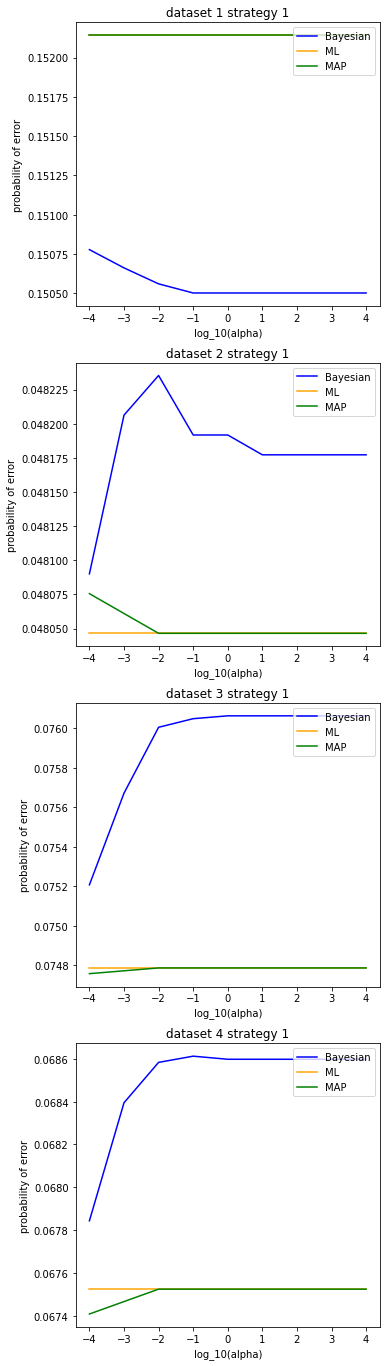

In [18]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,24))
title = ['strategy 1','strategy 2']
for i in range(len(FG)):
    for j in range(1):
        fig.add_subplot(4,2,(2*i+j)+1)
        x = np.log10(a.flatten())
        if j == 0:
            plt.plot(x,error_list_1[i],label = 'Bayesian',color='blue')
            plt.plot(x,error_list_ML[i],label = 'ML',color = 'orange')
            plt.plot(x,error_list_M1[i],label = 'MAP',color = 'green')
            plt.title('dataset %d '%(i+1) + title[j])
        #else:
            #plt.plot(x,error_list_2[i],label = 'Bayesian',color='blue')
            #plt.plot(x,error_list_ML[i],label = 'ML',color = 'orange')
            #plt.plot(x,error_list_M2[i],label = 'MAP',color = 'green')
            #plt.title('dataset %d '%(i+1) + title[j])
        plt.legend(loc='upper right')
        plt.xlabel('log_10(alpha)')
        plt.ylabel('probability of error')
plt.show()